In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
# import optuna
from sklearn.utils.class_weight import compute_class_weight

In [21]:
#Read in the pre-op, intra-op, stiffness, and outcomes data
preop = pd.read_csv('/content/drive/MyDrive/PCM_Classification/pre-op.csv')
intraop = pd.read_csv('/content/drive/MyDrive/PCM_Classification/intra-op.csv')
stiffness = pd.read_excel('/content/drive/MyDrive/PCM_Classification/stiffness_labeled.xlsx')
stiffness_2 = pd.read_excel('/content/drive/MyDrive/PCM_Classification/stiffness_labeled_2.xlsx')

In [22]:
# merged the pre-opp and intra-op data with the Stiffness labelled based on study number remove any rows that don't appear in stiffness_labelled drop these columns from pre-op procedure,surgeon,Other surgeon,surgdate,mv path,mv severeity,TVR added

merged_data = pd.merge(pd.merge(preop, intraop, on='study#', how='inner'), stiffness_2, on='study#', how='inner')
merged_data = merged_data.drop(columns=['procedure', 'surgeon', 'Other surgeon', 'surgdate', 'mv path', 'mv severeity', 'TVR added', 'MRN', '>48h'])

merged_data['>56h'] = (merged_data['iculengthofstay_hours'] > 56).astype(int)

#% increase in Stiffness as a feature, drop the original pre-bypass and post-bypass stiffness columns
#merged_data['% Increase Stiffness'] = ((merged_data['Post-bypass Stiffness'] - merged_data['Pre-bypass Stiffness']) / merged_data['Pre-bypass Stiffness']) * 100
#merged_data = merged_data.drop(columns=['Pre-bypass Stiffness', 'Post-bypass Stiffness'])

print(merged_data)

merged_data.columns

     study#  age  sex  race  ethnicity  heightcm  weightkg  phenylmcg  \
0         1   65    2     5          2     160.0      62.1      100.0   
1         2   63    1     5          2     177.8      82.8       50.0   
2         3   71    1     5          2     175.3      70.3     4400.0   
3         4   61    1     5          2     180.3      99.8     2200.0   
4         5   76    1     5          2     175.3      93.6     4350.0   
..      ...  ...  ...   ...        ...       ...       ...        ...   
139     166   53    1     5          2     182.9      73.0     3800.0   
140     167   77    1     5          3     185.4      93.9     1700.0   
141     168   67    2     5          2     165.1      66.3      700.0   
142     169   62    2     5          2     162.6      56.4     4200.0   
143     170   66    2     5          2     162.6      64.0      600.0   

     ephedmg  epimg  ...  vasomin  vasomax  ntgtotaldose  ntgmin  ntgmax  \
0        0.0  0.000  ...      0.0      0.0     

Index(['study#', 'age', 'sex', 'race', 'ethnicity', 'heightcm', 'weightkg',
       'phenylmcg', 'ephedmg', 'epimg', 'epimin', 'epimax', 'normg', 'normin',
       'normax', 'vasou', 'vasomin', 'vasomax', 'ntgtotaldose', 'ntgmin',
       'ntgmax', 'Pre-bypass Stiffness', 'Post-bypass Stiffness',
       'Regular Stiffness', 'iculengthofstay_hours', '>56h'],
      dtype='object')

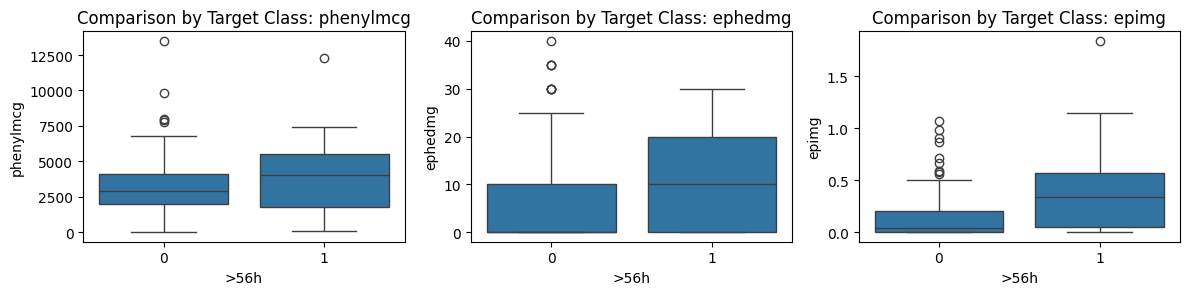

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_data' is your DataFrame and 'target' is the column with target classes
# List of columns to analyze
medication_columns = ['phenylmcg', 'ephedmg', 'epimg']

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Iterate over the list of medication dosage columns to create boxplots for each
for i, column in enumerate(medication_columns):
    plt.subplot(3, 3, i + 1)  # Adjust the grid parameters based on the number of variables
    sns.boxplot(x='>56h', y=column, data=merged_data)
    plt.title(f'Comparison by Target Class: {column}')
    plt.tight_layout()

plt.show()


In [25]:
columns_to_drop = ['phenylmcg', 'ephedmg', 'epimg', 'epimin', 'normg', 'normin', 'vasou', 'vasomin', 'ntgtotaldose', 'ntgmin']
merged_data = merged_data.drop(columns=columns_to_drop)

# Function to convert medication doses to categorical values based on thresholds
def convert_to_category(dose, threshold, high_label, low_label):
    return high_label if dose > threshold else low_label

# Apply the function to the epinephrine and norepinephrine max dose columns
merged_data['epi_cat'] = merged_data['epimax'].apply(lambda x: convert_to_category(x, 0.05, 1, 0))
merged_data['norepi_cat'] = merged_data['normax'].apply(lambda x: convert_to_category(x, 0.05, 1, 0))

# Define vasoactive usage as binary; assuming usage if any of the max doses are greater than zero
merged_data['vaso_usage'] = (merged_data[['epimax', 'normax', 'vasomax', 'ntgmax']].max(axis=1) > 0).astype(int)

print(merged_data[['epimax', 'normax', 'epi_cat', 'norepi_cat', 'vaso_usage']].head())

   epimax  normax  epi_cat  norepi_cat  vaso_usage
0    0.00    0.05        0           0           1
1    0.03    0.00        0           0           1
2    0.07    0.05        1           0           1
3    0.00    0.00        0           0           0
4    0.08    0.04        1           0           1


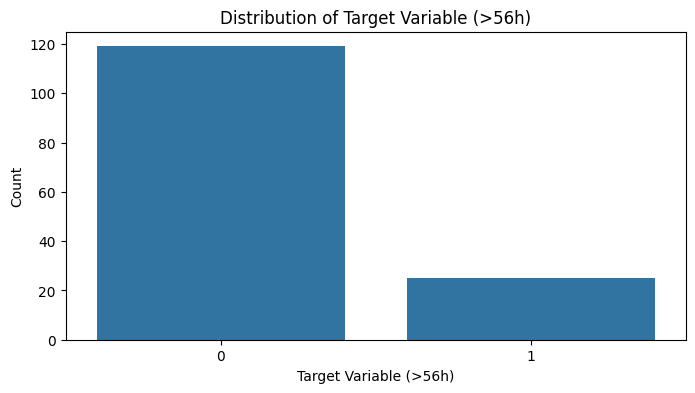

In [26]:
target_column = '>56h'

# Plotting the distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=target_column, data=merged_data)
plt.title('Distribution of Target Variable (>56h)')
plt.xlabel('Target Variable (>56h)')
plt.ylabel('Count')
plt.show()

In [27]:
import pandas as pd
from scipy.stats import fisher_exact

# Assuming 'merged_data' is your DataFrame and '>56h' is your binary target column
variables = ['epi_cat', 'norepi_cat', 'vaso_usage']

# Loop through each variable and perform Fisher's Exact test
for var in variables:
    # Create a contingency table
    table = pd.crosstab(merged_data['>56h'], merged_data[var])

    # Perform Fisher's Exact test
    oddsratio, p_value = fisher_exact(table)

    # Print the results
    print(f"Fisher's Exact Test for {var}: Odds Ratio={oddsratio:.2f}, P-value={p_value:.4f}")


Fisher's Exact Test for epi_cat: Odds Ratio=5.13, P-value=0.0038
Fisher's Exact Test for norepi_cat: Odds Ratio=1.69, P-value=0.2606
Fisher's Exact Test for vaso_usage: Odds Ratio=1.29, P-value=1.0000


In [ ]:
# prompt: stratified split for test and train sets

# Drop the study number column and iculengthofstay_hours column
merged_data_clf = merged_data.drop(columns=['study#', 'iculengthofstay_hours'])

# Separate features (X) and target (y)
X = merged_data_clf.drop(['>56h'], axis=1)
y = merged_data_clf['>56h']  # New target for >52 hours

# Define the cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
#Hyperparameter Tuning using Grid Search
import warnings
import optuna
warnings.filterwarnings('ignore', category=FutureWarning)

def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(knn_objective, n_trials=100)
print("Best parameters for KNN: ", knn_study.best_params)

def svm_objective(trial):
    C = trial.suggest_float('C', 0.1, 100.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    classifier_obj = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(svm_objective, n_trials=100)
print("Best parameters for SVM: ", svm_study.best_params)

def nb_objective(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e-8)
    prior_0 = trial.suggest_float('prior_0', 0.1, 0.9)
    prior_1 = 1 - prior_0
    priors = [prior_0, prior_1]

    classifier_obj = GaussianNB(var_smoothing=var_smoothing, priors=priors)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials=100)
print("Best parameters for NB: ", nb_study.best_params)

def lr_objective(trial):
    C = trial.suggest_float('C', 0.01, 10.0)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

    class_weight_0 = trial.suggest_float('class_weight_0', 0.1, 0.9)
    class_weight_1 = 1.0 - class_weight_0
    class_weight = {0: class_weight_0, 1: class_weight_1}

    classifier_obj = LogisticRegression(C=C, solver=solver, class_weight=class_weight, max_iter=10000)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(lr_objective, n_trials=100)
print("Best parameters for LR: ", lr_study.best_params)

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    class_weight_0 = trial.suggest_float('class_weight_0', 0.1, 0.9)
    class_weight_1 = 1.0 - class_weight_0
    class_weight = {0: class_weight_0, 1: class_weight_1}

    classifier_obj = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=100)
print("Best parameters for RF: ", rf_study.best_params)

[I 2024-05-11 14:43:22,259] A new study created in memory with name: no-name-14b6ff77-63dc-448e-9493-c041fc009b79
[I 2024-05-11 14:43:24,254] Trial 0 finished with value: 0.826388888888889 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.826388888888889.
[I 2024-05-11 14:43:24,315] Trial 1 finished with value: 0.826388888888889 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.826388888888889.
[I 2024-05-11 14:43:24,358] Trial 2 finished with value: 0.826388888888889 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.826388888888889.
[I 2024-05-11 14:43:24,409] Trial 3 finished with value: 0.826388888888889 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.826388888888889.
[I 2024-05-11 14:43:24,452] Trial 4 finished with value: 0.8263888888

Best parameters for KNN:  {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski'}


[I 2024-05-11 14:43:32,063] Trial 1 finished with value: 0.7916666666666666 and parameters: {'C': 84.6512710905411, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.7916666666666666.
[I 2024-05-11 14:43:32,146] Trial 2 finished with value: 0.7361111111111112 and parameters: {'C': 18.114946761018434, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.7916666666666666.
[I 2024-05-11 14:43:32,521] Trial 3 finished with value: 0.7986111111111112 and parameters: {'C': 28.51329026999565, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 3 with value: 0.7986111111111112.
[I 2024-05-11 14:43:32,602] Trial 4 finished with value: 0.7430555555555555 and parameters: {'C': 72.48596791916803, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.7986111111111112.
[I 2024-05-11 14:43:32,682] Trial 5 finished with value: 0.7569444444444443 and parameters: {'C': 72.50691269939077, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 3 with value: 0.7986111111

Best parameters for SVM:  {'C': 2.9676959161037795, 'kernel': 'sigmoid', 'gamma': 'auto'}


[I 2024-05-11 14:43:46,100] Trial 3 finished with value: 0.7847222222222223 and parameters: {'var_smoothing': 7.512962001605743e-09, 'prior_0': 0.7440014737670652}. Best is trial 2 with value: 0.7986111111111112.
[I 2024-05-11 14:43:46,149] Trial 4 finished with value: 0.7986111111111112 and parameters: {'var_smoothing': 1.8639864115978973e-09, 'prior_0': 0.3171608787685972}. Best is trial 2 with value: 0.7986111111111112.
[I 2024-05-11 14:43:46,192] Trial 5 finished with value: 0.7986111111111112 and parameters: {'var_smoothing': 9.83297680682138e-09, 'prior_0': 0.44445988777456114}. Best is trial 2 with value: 0.7986111111111112.
[I 2024-05-11 14:43:46,233] Trial 6 finished with value: 0.7847222222222223 and parameters: {'var_smoothing': 2.31493924703959e-09, 'prior_0': 0.6716691239024071}. Best is trial 2 with value: 0.7986111111111112.
[I 2024-05-11 14:43:46,289] Trial 7 finished with value: 0.7847222222222223 and parameters: {'var_smoothing': 5.1894784625984005e-09, 'prior_0': 0.8

Best parameters for NB:  {'var_smoothing': 6.847865476079513e-09, 'prior_0': 0.25781299180899603}


[I 2024-05-11 14:43:52,153] Trial 4 finished with value: 0.798611111111111 and parameters: {'C': 5.66644278792537, 'solver': 'saga', 'class_weight_0': 0.5063950004717885}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-05-11 14:43:52,203] Trial 5 finished with value: 0.7013888888888888 and parameters: {'C': 9.575173657615883, 'solver': 'newton-cg', 'class_weight_0': 0.29208550536054256}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-05-11 14:43:52,250] Trial 6 finished with value: 0.8194444444444445 and parameters: {'C': 6.6561955981007985, 'solver': 'newton-cg', 'class_weight_0': 0.6598452196879931}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-05-11 14:43:52,303] Trial 7 finished with value: 0.7569444444444445 and parameters: {'C': 5.508146186156097, 'solver': 'liblinear', 'class_weight_0': 0.346728050842393}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-05-11 14:43:52,361] Trial 8 finished with value: 0.6597222222222223 and parameters: {'C': 

Best parameters for LR:  {'C': 0.013073724989205171, 'solver': 'liblinear', 'class_weight_0': 0.6388802457489835}


[I 2024-05-11 14:44:02,387] Trial 0 finished with value: 0.826388888888889 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'auto', 'class_weight_0': 0.830167754445945}. Best is trial 0 with value: 0.826388888888889.
[I 2024-05-11 14:44:04,927] Trial 1 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 173, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'class_weight_0': 0.7353677717556639}. Best is trial 1 with value: 0.8333333333333334.
[I 2024-05-11 14:44:08,452] Trial 2 finished with value: 0.826388888888889 and parameters: {'n_estimators': 139, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight_0': 0.7397249022631756}. Best is trial 1 with value: 0.8333333333333334.
[I 2024-05-11 14:44:10,602] Trial 3 finished with value: 0.638888888888889 and parameters: {'n_estimators': 57, 'max_depth': 24, 'min_

Best parameters for RF:  {'n_estimators': 298, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'auto', 'class_weight_0': 0.48374065689685297}


In [ ]:
#Adjust classifiers with best parameters from Grid Search before CV
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski')
svm = SVC(C=3, gamma='auto', kernel='sigmoid', probability=True)
nb = GaussianNB(priors=[0.26, 0.74], var_smoothing=6.85e-09)
log_reg = LogisticRegression(C=0.013, solver='liblinear', max_iter=10000, class_weight={0:0.64, 1:0.36})
rf = RandomForestClassifier(
    max_depth=14,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=14,
    n_estimators=298,
    class_weight={0:0.5, 1:0.5},
    random_state=0
)

# weights = {
#     'KNN': round(0.0 * 10),
#     'SVM': round(0.29 * 10),
#     'Naive Bayes': round(0.19 * 10),
#     'Logistic Regression': round(0.12 * 10),
#     'Random Forest': round(0.41 * 10)
# }
weights = {
    'KNN': 0.2,
    'SVM': 0.175,
    'Naive Bayes': 0.175,
    'Logistic Regression': 0.2,
    'Random Forest': 0.25
}

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('nb', nb),
    ('log_reg', log_reg),
    ('rf', rf)],
    voting='soft',
    weights=[weights['KNN'], weights['SVM'], weights['Naive Bayes'], weights['Logistic Regression'], weights['Random Forest']]
)
classifiers = {
    'KNN': knn,
    'SVM': svm,
    'Naive Bayes': nb,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'Voting Classifier': voting_clf
}

In [ ]:
# Function to perform training and evaluation
def train_and_evaluate(classifier, X_train, y_train, X_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    return y_pred, y_proba

In [ ]:
# prompt: stratified split for test and train sets

# Drop the study number column and iculengthofstay_hours column
merged_data_clf = merged_data.drop(columns=['study#', 'iculengthofstay_hours'])

# Separate features (X) and target (y)
X = merged_data_clf.drop([ '>56h'], axis=1)
y_56 = merged_data_clf['>56h']  # New target for >56 hours

# Define the cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Assume X and y are your initial datasets and y_56 is the target variable you're interested in
y_0 = y_56

# Add an 'is_original' column to track original and synthetic samples
X['is_original'] = 1  # mark all existing data as original

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X.drop('is_original', axis=1), y_0)  # SMOTE on original features

# SMOTE doesn't output the origin of the rows, so you need to handle it manually:
X_resampled['is_original'] = X['is_original'].tolist() + [0] * (len(X_resampled) - len(X))  # Append [0]*number_of_synthetic_samples

X = X_resampled
y = y_resampled
print(X_resampled)

     age  sex  race  ethnicity    heightcm   weightkg    epimax    normax  \
0     65    2     5          2  160.000000  62.100000  0.000000  0.050000   
1     63    1     5          2  177.800000  82.800000  0.030000  0.000000   
2     71    1     5          2  175.300000  70.300000  0.070000  0.050000   
3     61    1     5          2  180.300000  99.800000  0.000000  0.000000   
4     76    1     5          2  175.300000  93.600000  0.080000  0.040000   
..   ...  ...   ...        ...         ...        ...       ...       ...   
233   74    1     5          2  172.190461  89.763556  0.047693  0.035962   
234   75    1     5          2  175.462231  93.269050  0.080000  0.040649   
235   77    1     5          2  167.152349  74.475509  0.000000  0.007617   
236   52    1     2          1  167.611584  85.500946  0.100000  0.297501   
237   69    2     5          2  155.951152  57.394108  0.696304  0.034815   

     vasomax  ntgmax  Pre-bypass Stiffness  Post-bypass Stiffness  \
0     

KNN - Correctly Classified Original Cases: 106 out of 144
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       119
           1       0.78      0.86      0.82       119

    accuracy                           0.81       238
   macro avg       0.81      0.81      0.81       238
weighted avg       0.81      0.81      0.81       238

Confusion Matrix for KNN:


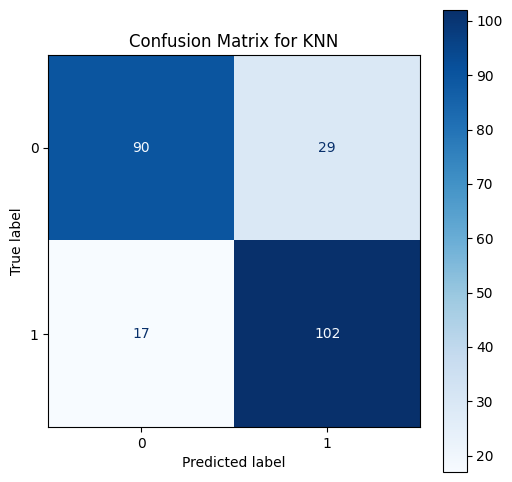

SVM - Correctly Classified Original Cases: 104 out of 144
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       119
           1       0.73      0.61      0.66       119

    accuracy                           0.69       238
   macro avg       0.70      0.69      0.69       238
weighted avg       0.70      0.69      0.69       238

Confusion Matrix for SVM:


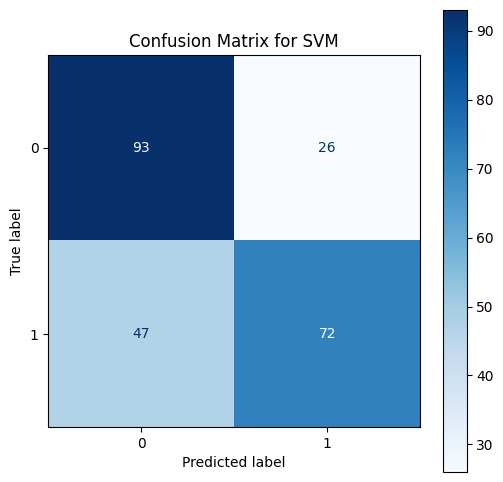

Naive Bayes - Correctly Classified Original Cases: 123 out of 144
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.59      0.97      0.73       119
           1       0.91      0.34      0.49       119

    accuracy                           0.65       238
   macro avg       0.75      0.65      0.61       238
weighted avg       0.75      0.65      0.61       238

Confusion Matrix for Naive Bayes:


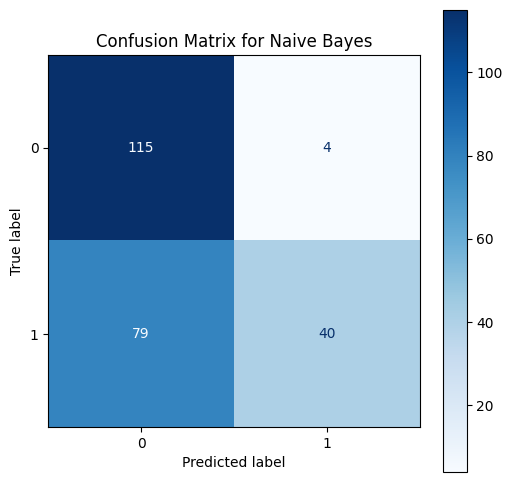

Logistic Regression - Correctly Classified Original Cases: 119 out of 144
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.92      0.75       119
           1       0.85      0.49      0.62       119

    accuracy                           0.70       238
   macro avg       0.75      0.70      0.69       238
weighted avg       0.75      0.70      0.69       238

Confusion Matrix for Logistic Regression:


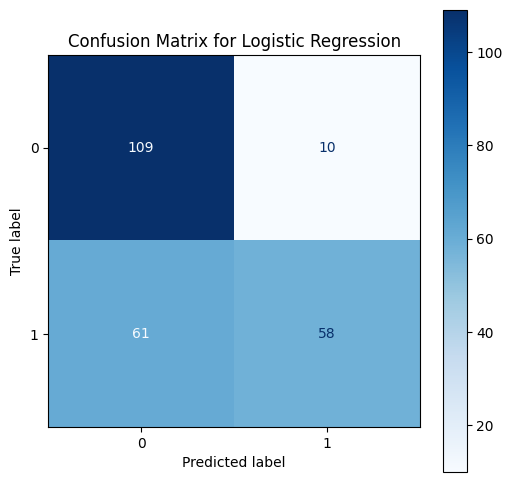

Random Forest - Correctly Classified Original Cases: 119 out of 144
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       119
           1       0.88      0.82      0.85       119

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.86      0.86      0.86       238

Confusion Matrix for Random Forest:


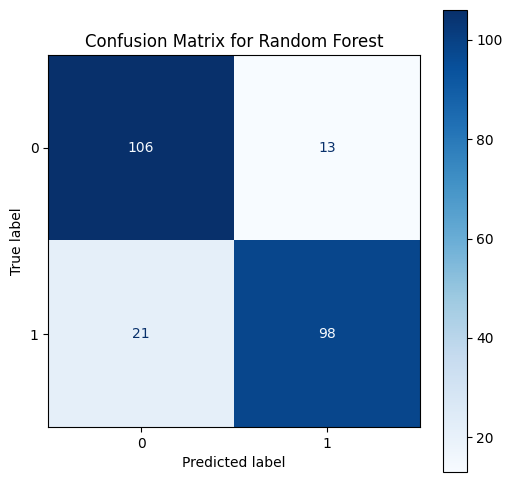

Voting Classifier - Correctly Classified Original Cases: 124 out of 144
Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       119
           1       0.92      0.66      0.76       119

    accuracy                           0.80       238
   macro avg       0.82      0.80      0.79       238
weighted avg       0.82      0.80      0.79       238

Confusion Matrix for Voting Classifier:


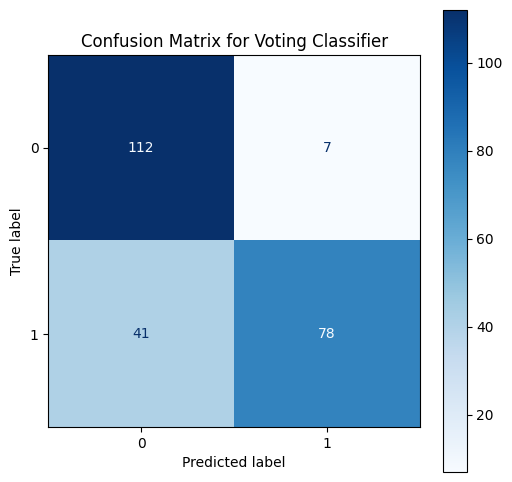

In [ ]:
## Original training program with no test set, JUST SKIP IT!!!
results = {name: {'y_test': [], 'y_pred': [], 'y_proba': [],'correct_ori':0, 'total_ori': 0} for name in classifiers}
# Cross-validation loop
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y[test_index]
    original_test = X_test['is_original'].to_numpy()  # track whether test instances are original or synthetic

    # Remove the 'is_original' column before training
    X_train = X_train.drop(columns=['is_original'])
    X_test = X_test.drop(columns=['is_original'])

    for name, clf in classifiers.items():
        y_pred, y_proba = train_and_evaluate(clf, X_train, y_train, X_test)
        results[name]['y_test'].extend(y_test)
        results[name]['y_pred'].extend(y_pred)
        results[name]['y_proba'].extend(y_proba)

         # Identify correctly classified original cases
        correct_original = (y_pred == y_test) & (original_test == 1)
        results[name]['correct_ori'] += np.sum(correct_original)
        results[name]['total_ori'] += np.sum(original_test == 1)

# After all folds, generate and print classification reports for each classifier
for name, data in results.items():
    print(f"{name} - Correctly Classified Original Cases: {data['correct_ori']} out of {data['total_ori']}")

    print(f"Classification Report for {name}:")

    report = classification_report(data['y_test'], data['y_pred'], zero_division=0)
    print(report)

    cm = confusion_matrix(data['y_test'], data['y_pred'])
    print(f"Confusion Matrix for {name}:")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(data['y_test'])).plot(values_format='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.86      0.96      0.91        26

    accuracy                           0.90        48
   macro avg       0.90      0.89      0.89        48
weighted avg       0.90      0.90      0.89        48

Confusion Matrix for KNN:


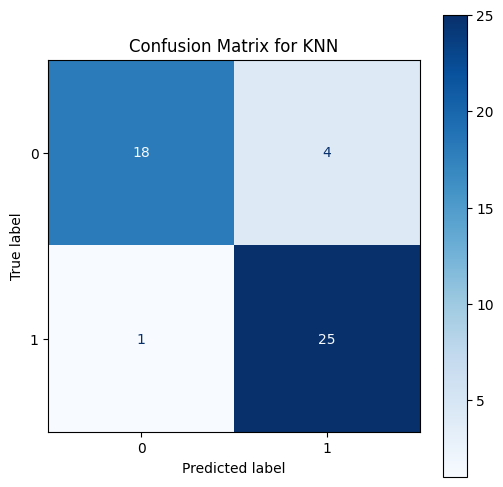

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.76      0.62      0.68        26

    accuracy                           0.69        48
   macro avg       0.70      0.69      0.69        48
weighted avg       0.70      0.69      0.69        48

Confusion Matrix for SVM:


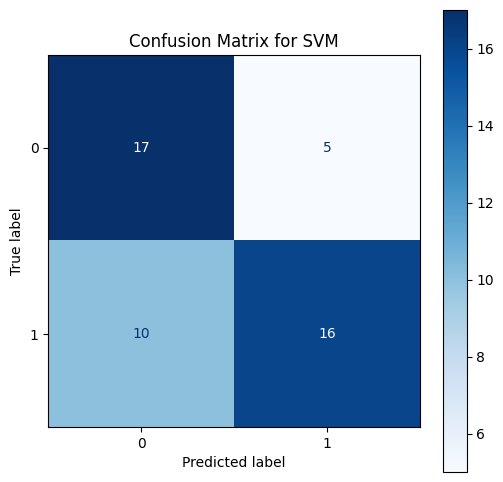

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        22
           1       1.00      0.31      0.47        26

    accuracy                           0.62        48
   macro avg       0.78      0.65      0.59        48
weighted avg       0.79      0.62      0.58        48

Confusion Matrix for Naive Bayes:


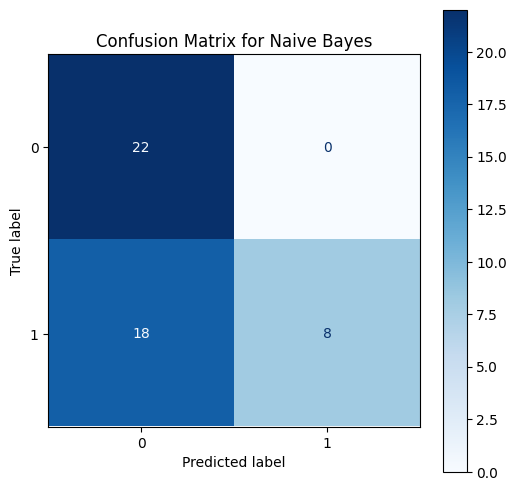

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.61      0.91      0.73        22
           1       0.87      0.50      0.63        26

    accuracy                           0.69        48
   macro avg       0.74      0.70      0.68        48
weighted avg       0.75      0.69      0.68        48

Confusion Matrix for Logistic Regression:


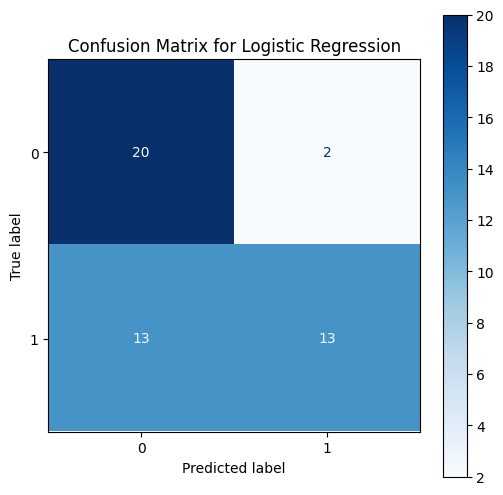

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        22
           1       0.95      0.81      0.88        26

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.88        48
weighted avg       0.89      0.88      0.88        48

Confusion Matrix for Random Forest:


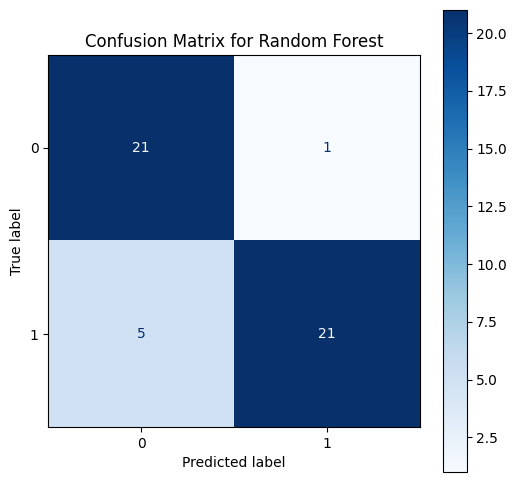

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        22
           1       1.00      0.65      0.79        26

    accuracy                           0.81        48
   macro avg       0.85      0.83      0.81        48
weighted avg       0.87      0.81      0.81        48

Confusion Matrix for Voting Classifier:


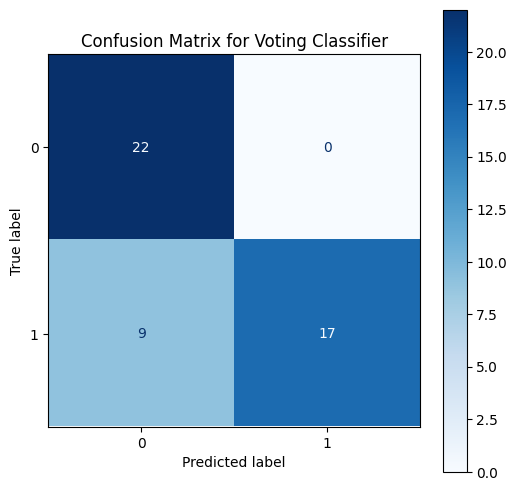

In [ ]:
## New with test set
from sklearn.model_selection import train_test_split

# Split the dataset into a training and a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Assume 'is_original' needs to be removed before training and testing
X_train_val = X_train_val.drop(columns=['is_original'])
X_test = X_test.drop(columns=['is_original'])

# Initialize the dictionary to collect results
results_0 = {name: {'y_test': [], 'y_pred': [], 'y_proba': []} for name in classifiers}

# Cross-validation on the training set
for train_index, val_index in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    for name, clf in classifiers.items():
        y_pred, y_proba = train_and_evaluate(clf, X_train, y_train, X_val)
        results_0[name]['y_test'].extend(y_val)
        results_0[name]['y_pred'].extend(y_pred)
        results_0[name]['y_proba'].extend(y_proba)

# Evaluation on the separate test dataset
results = {}
for name, clf in classifiers.items():
    y_pred_test, y_proba_test = train_and_evaluate(clf, X_train_val, y_train_val, X_test)
    results[name] = {
        'y_test': y_test,
        'y_pred': y_pred_test,
        'y_proba': y_proba_test,
        'classification_report': classification_report(y_test, y_pred_test, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred_test)
    }

    # Optionally plot the confusion matrix
for name, data in results.items():

    print(f"Classification Report for {name}:")

    report = classification_report(data['y_test'], data['y_pred'], zero_division=0)
    print(report)

    cm = confusion_matrix(data['y_test'], data['y_pred'])
    print(f"Confusion Matrix for {name}:")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(data['y_test'])).plot(values_format='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score


results_summary = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []} for name in classifiers}

for name, clf in classifiers.items():
    # Calculate metrics
    accuracy = accuracy_score(results_0[name]['y_test'], results_0[name]['y_pred'])
    precision = precision_score(results_0[name]['y_test'], results_0[name]['y_pred'], average='macro')
    recall = recall_score(results_0[name]['y_test'], results_0[name]['y_pred'], average='macro')
    f1 = f1_score(results_0[name]['y_test'], results_0[name]['y_pred'], average='macro')
    auc = roc_auc_score(results_0[name]['y_test'], results_0[name]['y_proba'], multi_class='ovr')

    # Append results for each fold
    results_summary[name]['accuracy'].append(accuracy)
    results_summary[name]['precision'].append(precision)
    results_summary[name]['recall'].append(recall)
    results_summary[name]['f1'].append(f1)
    results_summary[name]['auc'].append(auc)

final_results = {name: {} for name in classifiers}
for name in results_summary:
    final_results[name]['mean_accuracy'] = np.mean(results_summary[name]['accuracy'])
    final_results[name]['std_accuracy'] = np.std(results_summary[name]['accuracy'])
    final_results[name]['mean_precision'] = np.mean(results_summary[name]['precision'])
    final_results[name]['std_precision'] = np.std(results_summary[name]['precision'])
    final_results[name]['mean_recall'] = np.mean(results_summary[name]['recall'])
    final_results[name]['std_recall'] = np.std(results_summary[name]['recall'])
    final_results[name]['mean_f1'] = np.mean(results_summary[name]['f1'])
    final_results[name]['std_f1'] = np.std(results_summary[name]['f1'])
    final_results[name]['mean_auc'] = np.mean(results_summary[name]['auc'])
    final_results[name]['std_auc'] = np.std(results_summary[name]['auc'])

    print(f"{name} - Mean Accuracy: {final_results[name]['mean_accuracy']:.4f} +/- {final_results[name]['std_accuracy']:.4f}")
    print(f"{name} - Mean Precision: {final_results[name]['mean_precision']:.4f} +/- {final_results[name]['std_precision']:.4f}")
    print(f"{name} - Mean Recall: {final_results[name]['mean_recall']:.4f} +/- {final_results[name]['std_recall']:.4f}")
    print(f"{name} - Mean F1: {final_results[name]['mean_f1']:.4f} +/- {final_results[name]['std_f1']:.4f}")
    print(f"{name} - Mean AUC: {final_results[name]['mean_auc']:.4f} +/- {final_results[name]['std_auc']:.4f}")
    print("="*80)

KNN - Mean Accuracy: 0.7947 +/- 0.0000
KNN - Mean Precision: 0.8018 +/- 0.0000
KNN - Mean Recall: 0.7963 +/- 0.0000
KNN - Mean F1: 0.7940 +/- 0.0000
KNN - Mean AUC: 0.8748 +/- 0.0000
SVM - Mean Accuracy: 0.6789 +/- 0.0000
SVM - Mean Precision: 0.6842 +/- 0.0000
SVM - Mean Recall: 0.6769 +/- 0.0000
SVM - Mean F1: 0.6750 +/- 0.0000
SVM - Mean AUC: 0.7228 +/- 0.0000
Naive Bayes - Mean Accuracy: 0.6579 +/- 0.0000
Naive Bayes - Mean Precision: 0.7464 +/- 0.0000
Naive Bayes - Mean Recall: 0.6514 +/- 0.0000
Naive Bayes - Mean F1: 0.6186 +/- 0.0000
Naive Bayes - Mean AUC: 0.7626 +/- 0.0000
Logistic Regression - Mean Accuracy: 0.6947 +/- 0.0000
Logistic Regression - Mean Precision: 0.7268 +/- 0.0000
Logistic Regression - Mean Recall: 0.6906 +/- 0.0000
Logistic Regression - Mean F1: 0.6806 +/- 0.0000
Logistic Regression - Mean AUC: 0.7866 +/- 0.0000
Random Forest - Mean Accuracy: 0.8789 +/- 0.0000
Random Forest - Mean Precision: 0.8790 +/- 0.0000
Random Forest - Mean Recall: 0.8788 +/- 0.0000
Ra

In [ ]:
def plot_performance(results):
    # Iterate over each classifier
    for name, data in results.items():
        y_true = data['y_test']
        y_scores = data['y_proba']

        # Compute aggregated ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Compute aggregated Precision-Recall curve and area
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = average_precision_score(y_true, y_scores)

        # Plotting
        plt.figure(figsize=(12, 5))

        # ROC Curve
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc="lower right")

        # Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {name}')
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()
        plt.savefig(f'performance_{name}.png')

plot_performance(results)

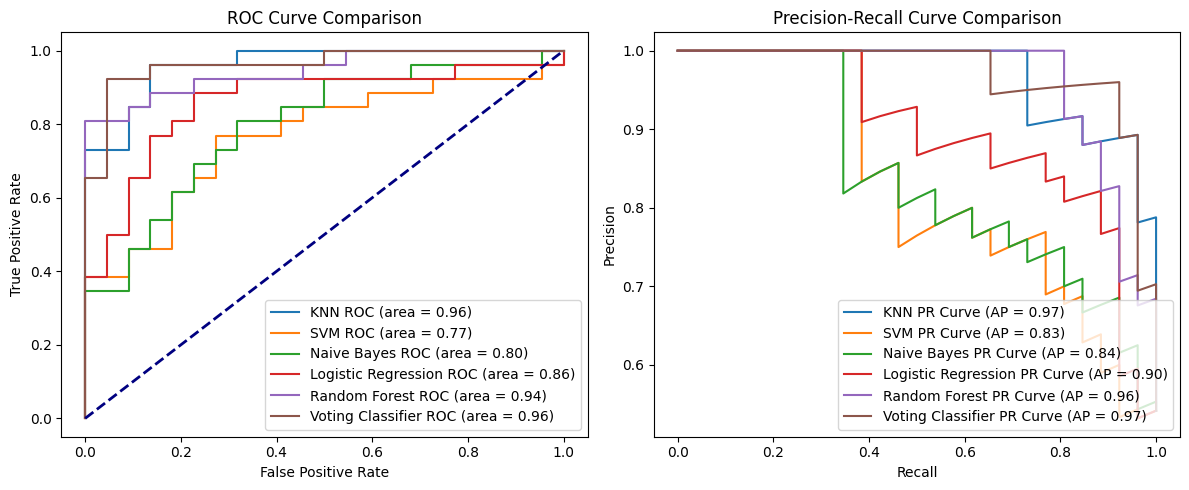

In [ ]:
def plot_performance(results):
    plt.figure(figsize=(12, 5))

    # Prepare the ROC subplot
    plt.subplot(1, 2, 1)
    for name, data in results.items():
        y_true = data['y_test']
        y_scores = data['y_proba']

        # Compute ROC curve and ROC area for each classifier
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} ROC (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")

    # Prepare the Precision-Recall subplot
    plt.subplot(1, 2, 2)
    for name, data in results.items():
        y_true = data['y_test']
        y_scores = data['y_proba']

        # Compute Precision-Recall curve and area for each classifier
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = average_precision_score(y_true, y_scores)
        plt.plot(recall, precision, label=f'{name} PR Curve (AP = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

plot_performance(results)

# Old version feature ranking, skip it

In [ ]:
# !pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

# Set up warnings to ignore less critical messages
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize a DataFrame to store the ranks for averaging later
methods = ['Permutation', 'Sequential', 'Shapley']
columns = [f"{name}_{method}" for name in classifiers for method in methods]
rankings_df = pd.DataFrame(index=X_train.columns, columns=columns)

for name, model in classifiers.items():
    if name == 'KNN' or name == 'Random Forest':
        print(f"Analysis for {name}")

        # Fit model
        model.fit(X_train, y_train)

        # Calculate permutation importance and store ranks
        perm_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        perm_ranks = pd.Series(perm_imp.importances_mean, index=X_train.columns).rank(method='min', ascending=False)
        rankings_df[f"{name}_Permutation"] = perm_ranks

        # Sequential Feature Selector
        sfs = SequentialFeatureSelector(model, n_features_to_select=15, direction='forward', scoring='accuracy').fit(X_train, y_train)
        sfs_ranks = pd.Series(np.nan, index=X_train.columns)
        selected_features = np.array(X_train.columns)[sfs.get_support()]
        sfs_ranks[selected_features] = range(1, len(selected_features) + 1)
        rankings_df[f"{name}_Sequential"] = sfs_ranks

        # Shapley Values Calculation
        if name == 'Random Forest':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            # If binary classification, we only use shap values for class 1
            shap_sum = np.abs(shap_values[1]).mean(axis=0) if isinstance(shap_values, list) else np.abs(shap_values).mean(axis=0)
        else:
            explainer = shap.Explainer(model.predict, X_train)
            shap_values = explainer.shap_values(X_test)
            shap_sum = np.abs(shap_values).mean(axis=0)

        shap_ranks = pd.Series(shap_sum, index=X_train.columns).rank(method='min', ascending=False)
        rankings_df[f"{name}_Shapley"] = shap_ranks

        print("\nFeature ranking based on permutation importance:")
        print(perm_ranks.sort_values())

        print("\nFeature ranking based on Sequential Feature Selector:")
        print(sfs_ranks.dropna().sort_values())

        print("\nFeature ranking based on Shapley values:")
        print(shap_ranks.sort_values())

        print("\n" + "="*80 + "\n")

# Exclude ranks that appear more than 10 times in any method
for column in rankings_df.columns:
    rank_counts = rankings_df[column].value_counts()
    common_ranks = rank_counts[rank_counts > 10].index
    rankings_df.loc[rankings_df[column].isin(common_ranks), column] = np.nan


Analysis for KNN

Feature ranking based on permutation importance:
weightkg                  1.0
age                       2.0
heightcm                  3.0
is_original               4.0
ethnicity                 5.0
race                      6.0
vaso_usage                7.0
sex                       8.0
epimax                    8.0
normax                    8.0
vasomax                   8.0
Pre-bypass Stiffness      8.0
ntgmax                   13.0
norepi_cat               13.0
epi_cat                  15.0
Post-bypass Stiffness    16.0
dtype: float64

Feature ranking based on Sequential Feature Selector:
sex                       1.0
race                      2.0
ethnicity                 3.0
heightcm                  4.0
weightkg                  5.0
epimax                    6.0
normax                    7.0
vasomax                   8.0
ntgmax                    9.0
Pre-bypass Stiffness     10.0
Post-bypass Stiffness    11.0
epi_cat                  12.0
norepi_cat             

ValueError: Data must be 1-dimensional, got ndarray of shape (16, 2) instead

# Shapley analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Assuming `rf` is your RandomForestClassifier
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Adjust if using a classifier that predicts probabilities for multiple classes
# We compute the average of the absolute SHAP values across all classes
if isinstance(shap_values, list):  # Check if SHAP values are given per class
    shap_values = np.abs(shap_values).mean(axis=0)  # Mean across class outputs if multi-class
else:
    shap_values = np.abs(shap_values)

shap_sum = shap_values.mean(axis=0).mean(axis=1)
feature_names = X_test.columns.tolist()
feature_importance = pd.Series(shap_sum, index=feature_names).sort_values(ascending=False)

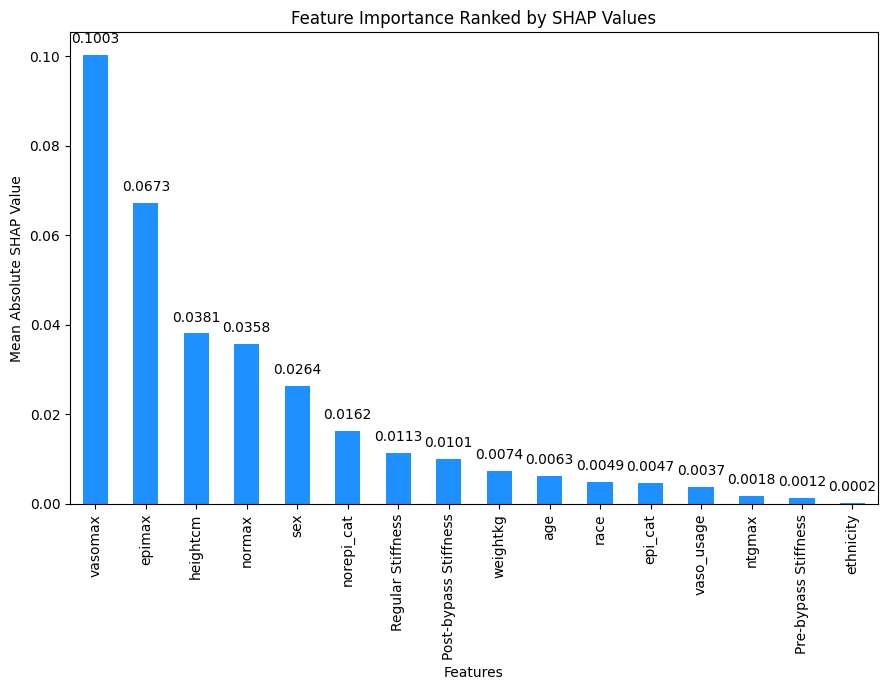

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

# Create a bar plot
feature_importance.plot(kind='bar', ax=ax, color='dodgerblue')

# Add labels to each bar
for i, v in enumerate(feature_importance):
    ax.text(i, v + 0.002, f"{v:.4f}", color='black', ha='center', va='bottom')

ax.set_title('Feature Importance Ranked by SHAP Values')
ax.set_ylabel('Mean Absolute SHAP Value')
ax.set_xlabel('Features')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Shapley of KNN

In [ ]:
import shap

# Create the SHAP explainer - using Explainer for non-tree models
explainer = shap.Explainer(knn.predict_proba, shap.sample(X_train_val, 100))
shap_values = explainer.shap_values(shap.sample(X_test, 100))


PermutationExplainer explainer: 49it [00:11,  4.03it/s]                        


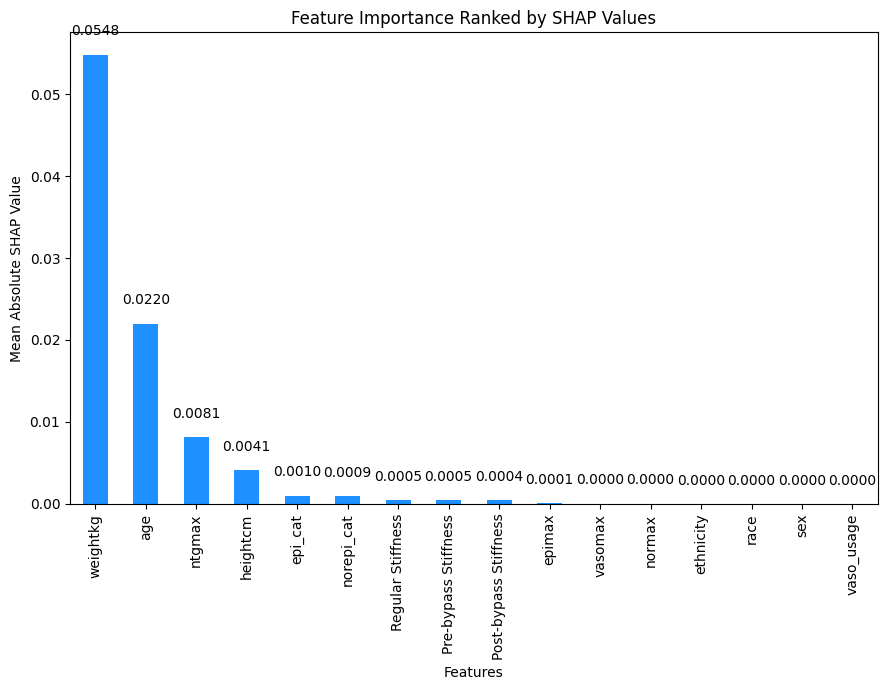

In [ ]:
# Adjust if using a classifier that predicts probabilities for multiple classes
# We compute the average of the absolute SHAP values across all classes
if isinstance(shap_values, list):  # Check if SHAP values are given per class
    shap_values = np.abs(shap_values).mean(axis=0)  # Mean across class outputs if multi-class
else:
    shap_values = np.abs(shap_values)

shap_sum = shap_values.mean(axis=0).mean(axis=1)
feature_names = X_test.columns.tolist()
feature_importance = pd.Series(shap_sum, index=feature_names).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(9, 7))

# Create a bar plot
feature_importance.plot(kind='bar', ax=ax, color='dodgerblue')

# Add labels to each bar
for i, v in enumerate(feature_importance):
    ax.text(i, v + 0.002, f"{v:.4f}", color='black', ha='center', va='bottom')

ax.set_title('Feature Importance Ranked by SHAP Values')
ax.set_ylabel('Mean Absolute SHAP Value')
ax.set_xlabel('Features')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Permuation importance does not work for RF and KNN? Let it go

In [ ]:
from sklearn.inspection import permutation_importance

# Set up warnings to ignore less critical messages
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
# Calculate permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Convert the importances into a DataFrame for easier handling
perm_importances_df = pd.DataFrame(perm_importance.importances_mean, index=X_train_val.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)


# Sequential Feature Selection/Seletor Ranking

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer, accuracy_score

# We'll modify the approach to assess one feature at a time
individual_features_score = {}

for feature in X_train_val.columns:
    sfs = SFS(rf,
              k_features=1,
              forward=True,
              floating=False,
              scoring=make_scorer(accuracy_score),
              cv=5)
    sfs.fit(X_train_val[[feature]], y_train_val)
    individual_features_score[feature] = sfs.k_score_  # Store the score of the feature

# Convert scores to DataFrame for easier handling
sfs_scores_df = pd.DataFrame(list(individual_features_score.items()), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)

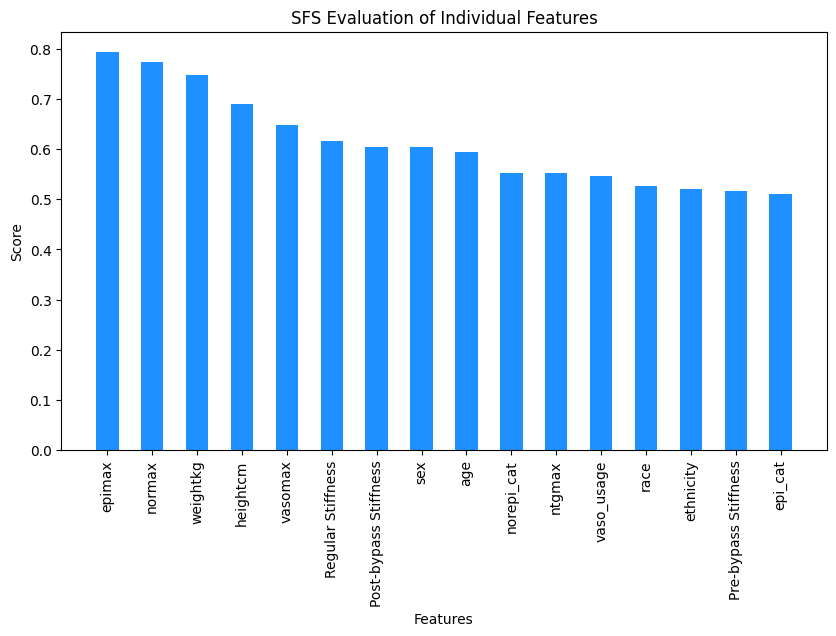

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 7))
# Plotting SFS Scores with thinner bars by setting the 'width' parameter
ax1.bar(sfs_scores_df['Feature'], sfs_scores_df['Score'], color='dodgerblue', width=0.5)  # Adjust the width here
ax1.set_title('SFS Evaluation of Individual Features')
ax1.set_ylabel('Score')
ax1.set_xlabel('Features')
ax1.tick_params(axis='x', rotation=90)

# Adjust the layout
# You can provide parameters to 'tight_layout' to control the spacing
plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)  # Increase padding to prevent tightness
plt.show()


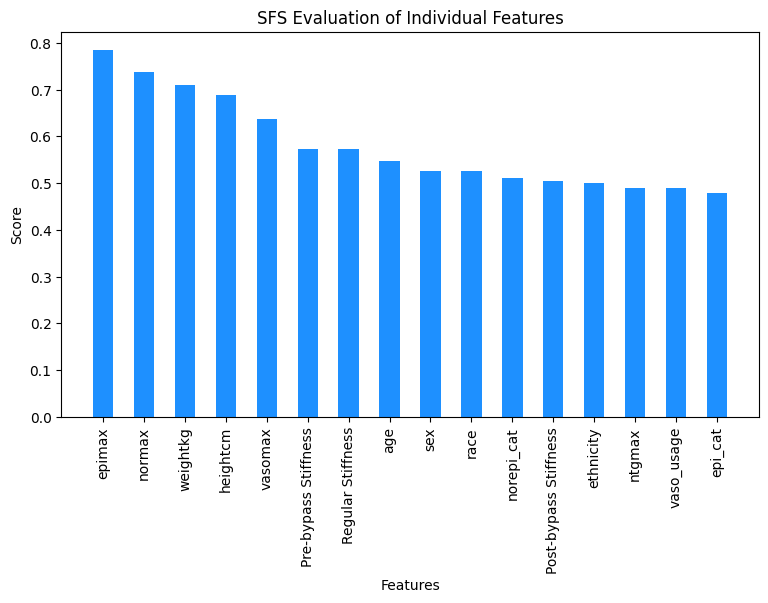

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Individual feature performance using SFS
individual_features_score = {}
for feature in X_train_val.columns:
    sfs = SFS(knn,
              k_features=1,
              forward=True,
              floating=False,
              scoring='accuracy',
              cv=5)
    sfs.fit(X_train_val[[feature]], y_train_val)
    individual_features_score[feature] = sfs.k_score_  # Store the score of the feature

# Convert scores to DataFrame and plot
sfs_scores_df = pd.DataFrame(list(individual_features_score.items()), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)

fig, ax1 = plt.subplots(figsize=(9, 5))
# Plotting SFS Scores with thinner bars by setting the 'width' parameter
ax1.bar(sfs_scores_df['Feature'], sfs_scores_df['Score'], color='dodgerblue', width=0.5)  # Adjust the width here
ax1.set_title('SFS Evaluation of Individual Features')
ax1.set_ylabel('Score')
ax1.set_xlabel('Features')
ax1.tick_params(axis='x', rotation=90)


# No Update with this figure(May 11)

Mean Feature Ranks Across All Methods:
age                       2.0
weightkg                  3.2
heightcm                  3.6
race                      4.2
ethnicity                 4.2
sex                       4.8
epimax                    7.6
normax                    7.6
is_original               7.8
Pre-bypass Stiffness      8.0
ntgmax                    8.4
vasomax                  8.75
norepi_cat                9.4
vaso_usage               10.2
Post-bypass Stiffness    10.4
epi_cat                  11.2
Name: Mean Rank, dtype: object


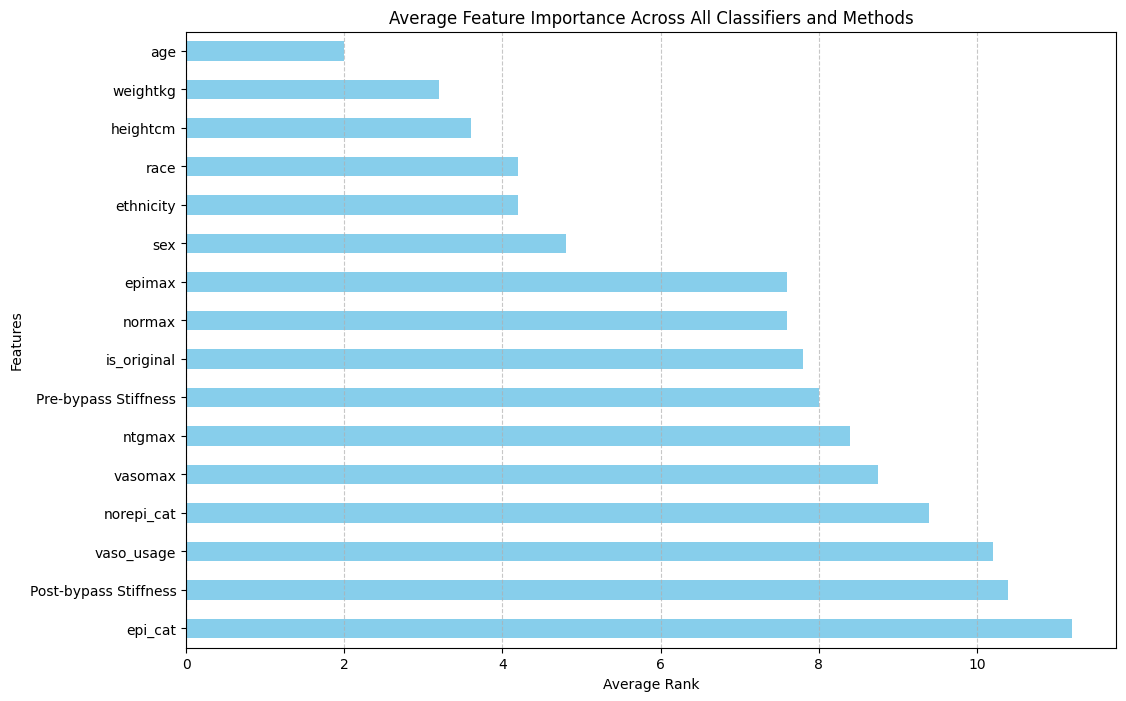

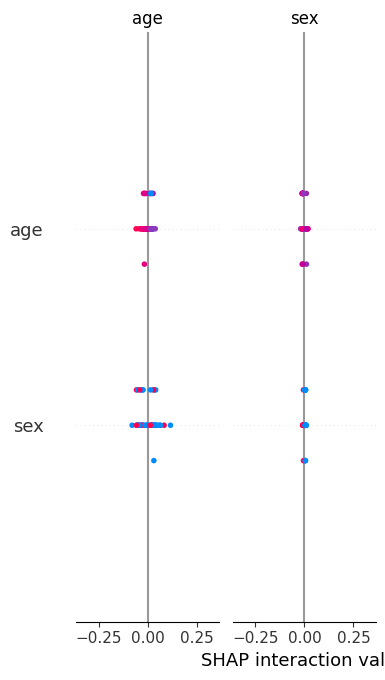

In [ ]:
# Calculate the mean ranks across all methods and classifiers
rankings_df['Mean Rank'] = rankings_df.mean(axis=1)
print("Mean Feature Ranks Across All Methods:")
print(rankings_df['Mean Rank'].sort_values())

# Plotting the Mean Rank Bar Plot
mean_rank_series = rankings_df['Mean Rank'].sort_values()
plt.figure(figsize=(12, 8))
mean_rank_series.plot(kind='barh', color='skyblue')
plt.title('Average Feature Importance Across All Classifiers and Methods')
plt.xlabel('Average Rank')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Highest rank on top
plt.show()

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train.columns)

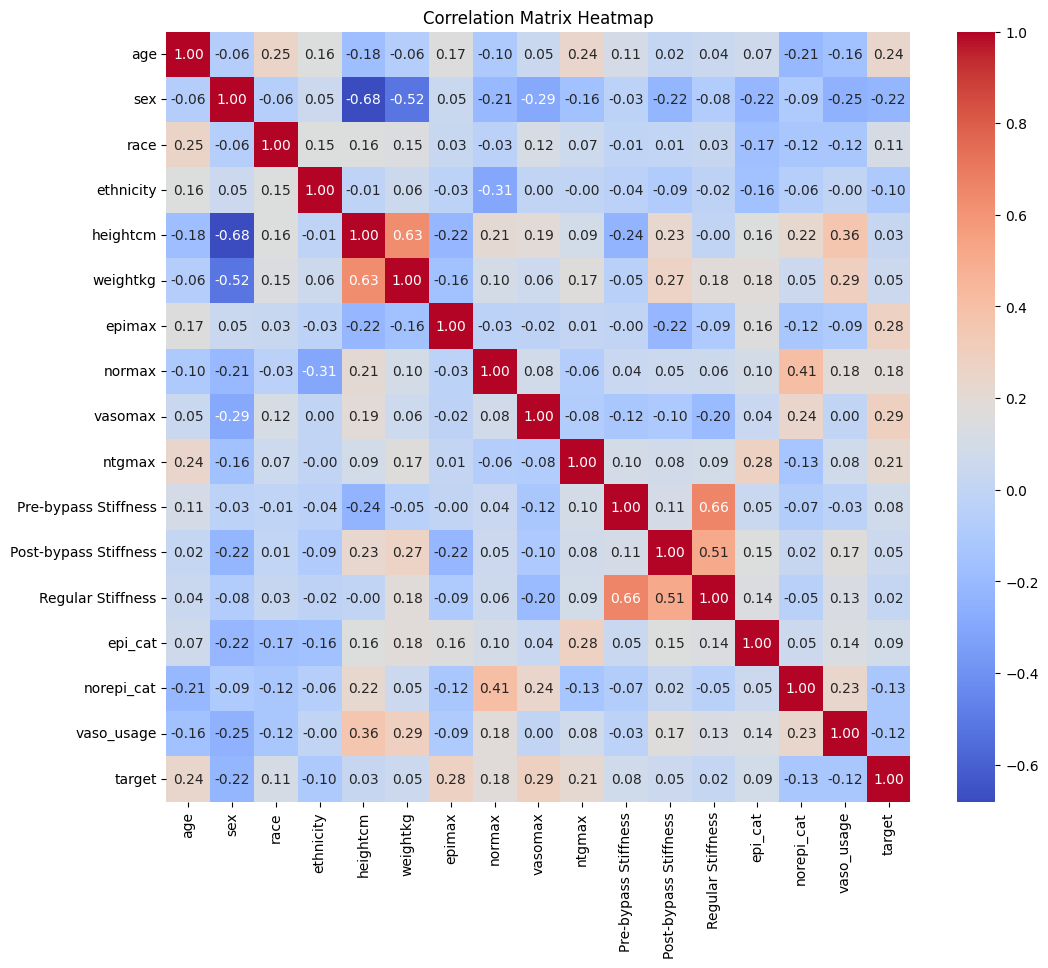

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the features and target variable into a single DataFrame for correlation analysis
data_for_corr = X_train.copy()
data_for_corr['target'] = y_train  # Adding the target variable to the DataFrame

# Calculate the correlation matrix
corr_matrix = data_for_corr.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))  # You can adjust the size as needed
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')

# Save the figure
plt.savefig('./correlation_matrix_heatmap.png', dpi=300, bbox_inches='tight')  # Adjust filename and dpi as needed
plt.show()  # Show the plot as the last step



Text(0, 0.5, 'Correlation Coefficient')

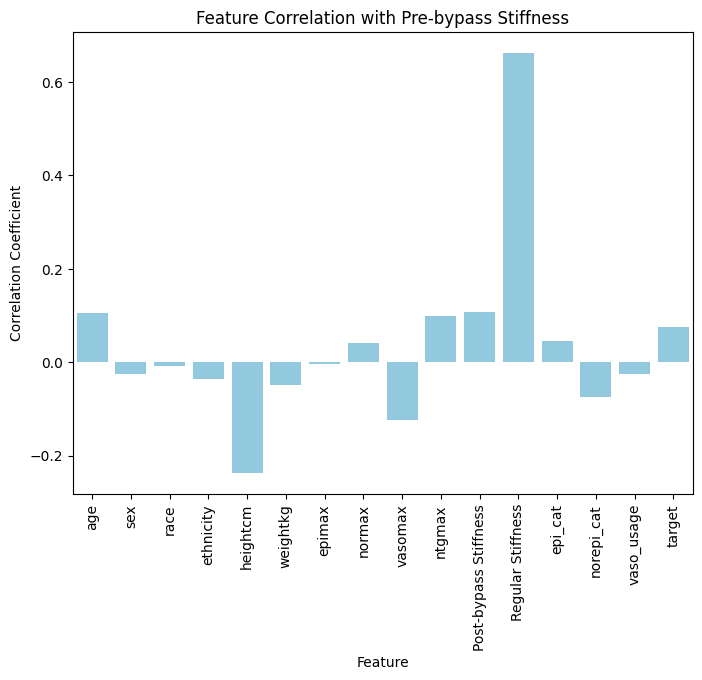

In [ ]:
target_corr = corr_matrix['Pre-bypass Stiffness'].drop('Pre-bypass Stiffness')

# Create a figure to visualize the correlation
plt.figure(figsize=(8, 6))  # Adjust the size as needed
target_corr_plot = sns.barplot(x=target_corr.index, y=target_corr.values, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.title('Feature Correlation with Pre-bypass Stiffness')
plt.xticks(rotation=90)  # Rotate labels for better readability if needed
plt.ylabel('Correlation Coefficient')